In [1]:
import h5py
import numpy as np
import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
from matplotlib import pyplot as plt

In [2]:
file_name = '../../fastMRIdatasets/singlecoil_val/file1000108.h5'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.001068150969929247, 'norm': 0.29132376113071917, 'patient_id': '120a9ed15c7402b4d558d0e522ed2dcb77b53d365ce5ec1eabe0a4137b12207d'}


In [3]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(37, 640, 368)


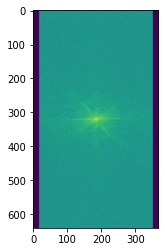

In [4]:
plt.imshow(np.log(np.abs(volume_kspace[20]) + 1e-9))
plt.show()

In [5]:
slice_kspace = T.to_tensor(volume_kspace[20])
slice_image = fastmri.ifft2c(slice_kspace)
slice_image_abs = fastmri.complex_abs(slice_image)

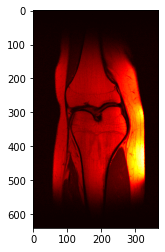

In [6]:
plt.imshow(np.abs(slice_image_abs), cmap='hot')
plt.show()

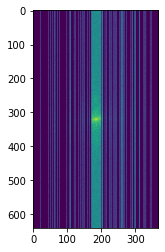

In [32]:
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
# mask_func = EquispacedMaskFunc(center_fractions=[0.01], accelerations=[8])
masked_kspace, mask = T.apply_mask(slice_kspace, mask_func)
plt.imshow(np.log(np.abs(masked_kspace[:,:,0]) + 1e-9))
plt.show()

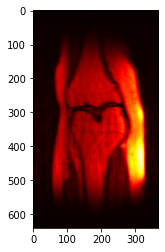

In [33]:
sampled_image = fastmri.ifft2c(masked_kspace)
sampled_image_abs = fastmri.complex_abs(sampled_image)
plt.imshow(np.abs(sampled_image_abs), cmap='hot')
plt.show()

In [34]:
import pytorch_lightning as pl
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule

In [35]:
model = UnetModule.load_from_checkpoint('../fastmri_examples/unet/unet/unet_demo/checkpoints/epoch=7.ckpt')

In [36]:
reconstructed_image = model(sampled_image_abs.unsqueeze(0))[0].detach()

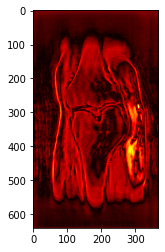

In [37]:
plt.imshow(np.abs(reconstructed_image), cmap='hot')
plt.show()

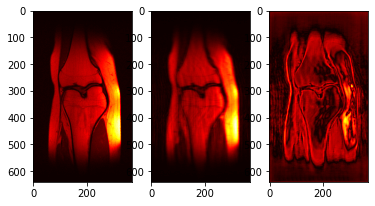

In [38]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(np.abs(slice_image_abs), cmap='hot')
ax[1].imshow(np.abs(sampled_image_abs), cmap='hot')
ax[2].imshow(np.abs(reconstructed_image), cmap='hot')
plt.show()